In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as mlt
import seaborn as sp
from torch.autograd import Variable
from torch import autograd
from datetime import datetime
import matplotlib.pyplot as plt
from datetime import timedelta
import sys
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score
from scipy.stats import ks_2samp
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [1]:
columns = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Hour', 'Sum']

In [275]:
%run ../Pre_process/Data_preprocess.ipynb
%run ../Pre_process/Data_postprocess.ipynb
%run Model/Gan_model.ipynb
%run Model/Seq2seq.ipynb
%run Model/ConvGan.ipynb
%run Model/AutoEncoder.ipynb
%run Model/Mean_imputation.ipynb
%run Model/KNN_imputer.ipynb
%run train.ipynb
%run ../visualize.ipynb
%run test.ipynb
%run ../validation.ipynb

In [276]:
#pre_process_dataset("Data/Raw/boulder_2021.csv", 'boulder')
# pre_process_dataset("Data/Raw/sap.csv", 'sap')

In [277]:
#df = pd.read_csv(processed_data_csv)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)
#df1 = pd.read_csv(processed_data_csv)
data2 = pd.read_csv("../Data/Processed/acn_data_with_zero.csv")
data1 = pd.read_csv("../Data/Processed/palo_alto_data_with_zero.csv")
data3 = pd.read_csv("../Data/Processed/boulder_data_with_zero.csv")
data3 = data3.loc[(data3['Start'] >= '2019-01-01 00:00:00') & (data3['Start'] <= '2019-12-31 23:00:00')]
data1 = data1.loc[(data1['Start'] >= '2017-01-01 00:00:00') & (data1['Start'] <= '2018-01-01 23:00:00')]
data2 = data2.loc[(data2['Start'] >= '2018-01-02 00:00:00') & (data2['Start'] <= '2018-12-31 23:00:00')]
df = pd.concat([data1, data2, data3], axis=0).reset_index(drop=True)
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)
#df.drop(columns=['Start', 'Year', 'Day of week', 'Week Day', 'Month', 'Day of month'], inplace=True)


In [278]:
input_size = df.shape[1]
hidden_size = input_size * 2

In [279]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns)
#df = pd.DataFrame(df, columns=['Energy'])

In [280]:
train_ratio = 0.70

In [281]:
missing_train, real_train, mask_train, missing_test, real_test, mask_test = get_train_test_dataset_imputation(df, train_ratio)

In [282]:
step_per_epoch = len(missing_train) // batch_size

# Converting to tensor
real_train = torch.from_numpy(real_train).float().to(device)
missing_train = torch.from_numpy(missing_train).float().to(device)
mask_train = torch.from_numpy(mask_train).float().to(device)

# GAN Model

In [1064]:
learning_rate = 0.001

In [1070]:
discriminator = Discriminator(input_size, hidden_size, 1).to(device)
generator = Generator(input_size, hidden_size, input_size).to(device)
optimizer_discriminator = torch.optim.SGD(discriminator.parameters(), lr = learning_rate)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr = learning_rate)

In [1071]:
loss_function_MSE = nn.MSELoss()
loss_function = nn.BCELoss()

In [1072]:
real_dataset, gen_dataset, errors_generator, errors_discriminator = train_Gan(generator, discriminator, optimizer_discriminator, optimizer_generator, loss_function, loss_function_MSE, real_train, missing_train, mask_train, step_per_epoch)

Epoch: 0 Loss D.: 1.3648898601531982 Loss G.: 0.91767418384552 mmd: 0.15858612954616547
Epoch: 1 Loss D.: 1.3690381050109863 Loss G.: 0.8882548213005066 mmd: 0.14083118736743927
Epoch: 2 Loss D.: 1.3684344291687012 Loss G.: 0.8806670904159546 mmd: 0.13785095512866974
Epoch: 3 Loss D.: 1.3682652711868286 Loss G.: 0.8762134313583374 mmd: 0.13777244091033936
Epoch: 4 Loss D.: 1.3679742813110352 Loss G.: 0.8725104928016663 mmd: 0.13760733604431152
Epoch: 5 Loss D.: 1.36745023727417 Loss G.: 0.8696144819259644 mmd: 0.13753151893615723
Epoch: 6 Loss D.: 1.3669356107711792 Loss G.: 0.8666789531707764 mmd: 0.13703559339046478
Epoch: 7 Loss D.: 1.3680146932601929 Loss G.: 0.8512670397758484 mmd: 0.12523043155670166
Epoch: 8 Loss D.: 1.367749810218811 Loss G.: 0.8468143343925476 mmd: 0.12235909700393677
Epoch: 9 Loss D.: 1.3672796487808228 Loss G.: 0.8452494144439697 mmd: 0.12195584923028946
Epoch: 10 Loss D.: 1.3667268753051758 Loss G.: 0.8444446325302124 mmd: 0.12194592505693436
Epoch: 11 Loss

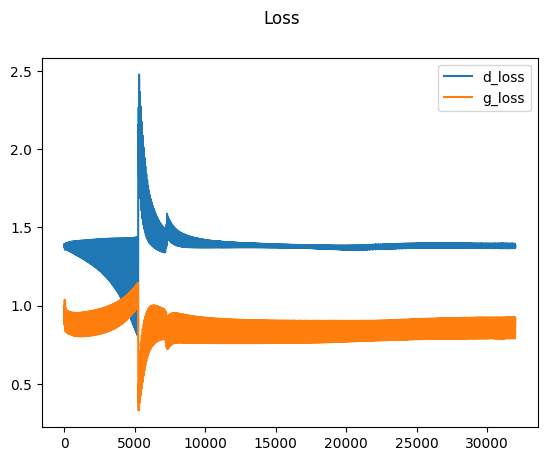

In [1073]:
mlt.suptitle('Loss')
mlt.plot(errors_discriminator, label='d_loss')
mlt.plot(errors_generator, label='g_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

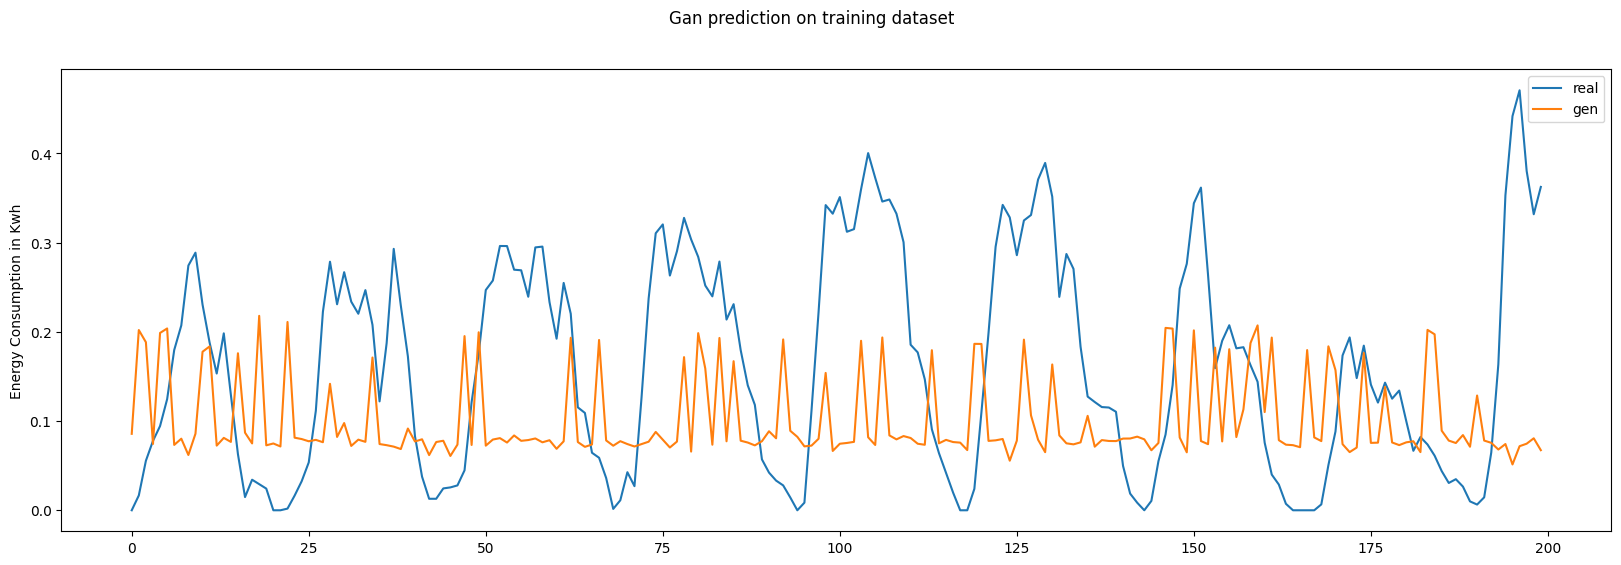

In [1074]:
# test_gen_dataset = gen_dataset
tr = real_dataset[:200, -1, 1].view(-1)
te = gen_dataset[:200, -1, 1].view(-1)
mlt.figure(figsize=(20, 6))
mlt.suptitle('Gan prediction on training dataset')
plt.ylabel('Energy Consumption in Kwh')
mlt.plot(tr.detach().cpu().numpy(), label='real')
mlt.plot(te.detach().cpu().numpy(), label='gen')
mlt.legend()
#mlt.savefig('./Results/train_res_impute.png')
mlt.show()

In [1075]:
ks_statistic, p_value = ks_2samp(tr.detach().cpu().numpy(), te.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.385
P-value: 1.3261055712130201e-13


In [1717]:
generator.eval()

Generator(
  (encoder_lstm): LSTM(1, 6, batch_first=True, bidirectional=True)
  (encoder_conv1): Conv1d(1, 6, kernel_size=(3,), stride=(1,), padding=(1,))
  (batchNorm1): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_lstm): LSTM(18, 6, batch_first=True, bidirectional=True)
  (decoder_linear): Linear(in_features=12, out_features=1, bias=True)
  (activation): ReLU()
)

In [889]:
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution

# Generate random data from a normal distribution
random_data = np.random.normal(loc=mean, scale=std_dev, size=(batch_size, lag_size, 1))
#random_data = np.clip(random_data, 0, 1)
random_data = torch.tensor(random_data,dtype=torch.float32, requires_grad=True).to(device)

In [890]:
real_test = torch.from_numpy(real_test).float().to(device)
missing_test = torch.from_numpy(missing_test).float().to(device)
mask_test = torch.from_numpy(mask_test).float().to(device)

In [854]:
real_data, real_label = gen_real_batch(real_test.shape[0], 0, real_test)
z_input, mask_input = gen_z_input(batch_size, 0, missing_test, mask_test)

In [857]:
input_test = z_input + random_data

In [858]:
ttt = generator(input_test)

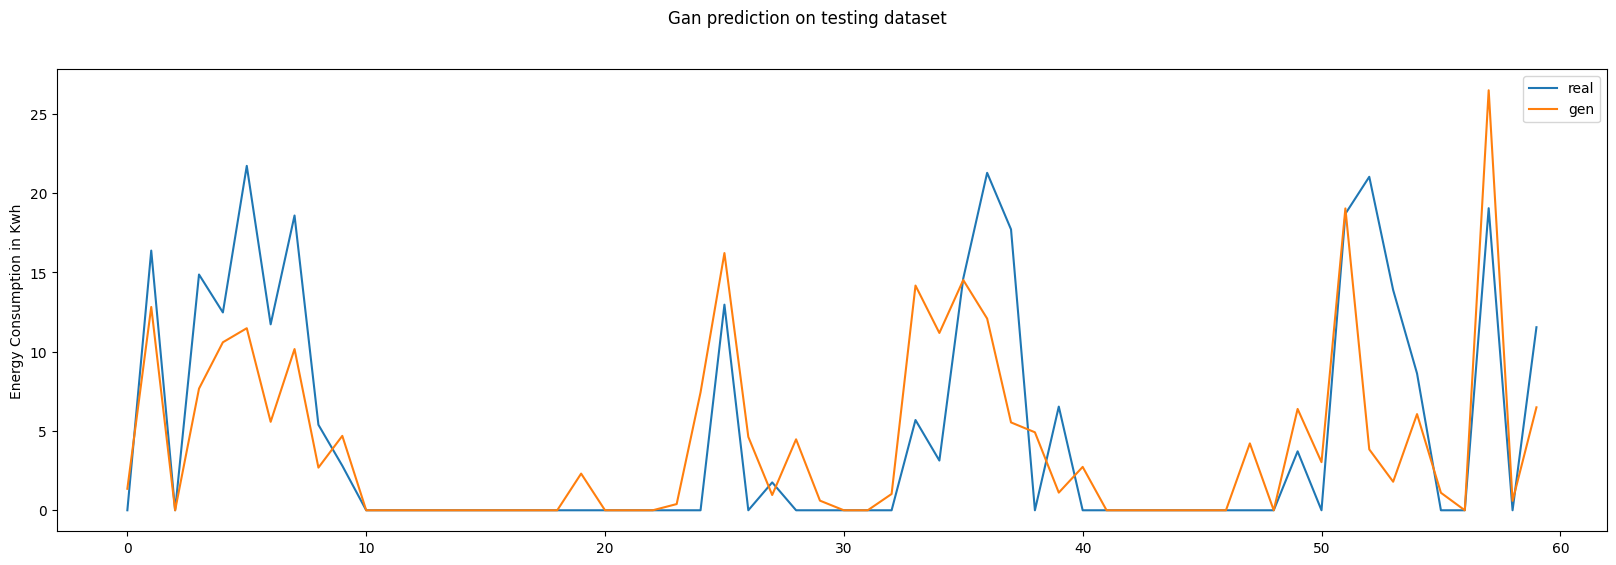

In [860]:
tr2 = z_input[:, -1, 0].view(-1)
te2 = ttt[:, -1, 0].view(-1)
# for i in range(len(te)):
#     te[i] = max(0, te[i])
#     if te[i] > 0:
#         te[i] = te[i] + 0.2
mlt.figure(figsize=(20, 6))
mlt.suptitle('Gan prediction on testing dataset')
mlt.plot(tr2.detach().cpu().numpy(), label='real')
mlt.plot(te2.detach().cpu().numpy(), label='gen')
plt.ylabel('Energy Consumption in Kwh')
mlt.legend()
#mlt.savefig('./Results/test_res_inpute.png')
mlt.show()

In [538]:
RMSE = mean_squared_error(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy(), squared=False)
print(f'RMSE:{RMSE}')

mae = mean_absolute_error(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy())
print("MSE:", mse)

RMSE:0.11749842017889023
MAE: 0.08268812
MSE: 0.013805878


In [539]:
RMSE = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy(), squared=False)
print(f'Test dataset RMSE:{RMSE}')

mae = mean_absolute_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MSE:", mse)

Test dataset RMSE:0.07364697009325027
MAE: 0.057413463
MSE: 0.005423876


In [861]:
ks_statistic, p_value = ks_2samp(tr2.detach().cpu().numpy(), te2.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.23333333333333334
P-value: 0.07607524222884415


In [486]:
alpha = 0.05  
if p_value < alpha:
    print("Reject the null hypothesis: The samples come from different distributions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the samples.")

Fail to reject the null hypothesis: There is no significant difference between the samples.


# Seq2Seq Conv

Trainning------------------------------------------------------------------------------------------------------------------------------

In [283]:
model = Seq2SeqConv1D(input_size, hidden_size, input_size).to(device)
#model = Seq2SeqAttention(input_size, hidden_size, input_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.005)
loss_function_seq2seq = nn.MSELoss()

In [284]:
real_dataset, gen_dataset, errors_generator, mask_data = train_Seq2Seq(model, optimizer, loss_function_seq2seq, real_train, missing_train, mask_train, step_per_epoch)

Epoch: 0 Loss G.: 58.95104217529297
Epoch: 1 Loss G.: 36.29608154296875
Epoch: 2 Loss G.: 27.791942596435547
Epoch: 3 Loss G.: 22.649364471435547
Epoch: 4 Loss G.: 19.85438346862793
Epoch: 5 Loss G.: 17.8236026763916
Epoch: 6 Loss G.: 16.001102447509766
Epoch: 7 Loss G.: 14.392638206481934
Epoch: 8 Loss G.: 13.125925064086914
Epoch: 9 Loss G.: 12.10023307800293
Epoch: 10 Loss G.: 11.051108360290527
Epoch: 11 Loss G.: 10.157462120056152
Epoch: 12 Loss G.: 9.180081367492676
Epoch: 13 Loss G.: 8.532079696655273
Epoch: 14 Loss G.: 7.954032897949219
Epoch: 15 Loss G.: 7.470783710479736
Epoch: 16 Loss G.: 6.927903652191162
Epoch: 17 Loss G.: 6.510554313659668
Epoch: 18 Loss G.: 6.139779567718506
Epoch: 19 Loss G.: 5.953861713409424
Epoch: 20 Loss G.: 5.676409721374512
Epoch: 21 Loss G.: 5.346676826477051
Epoch: 22 Loss G.: 5.158294200897217
Epoch: 23 Loss G.: 5.020928859710693
Epoch: 24 Loss G.: 4.767293453216553
Epoch: 25 Loss G.: 4.641738414764404
Epoch: 26 Loss G.: 4.469381809234619
Epoch

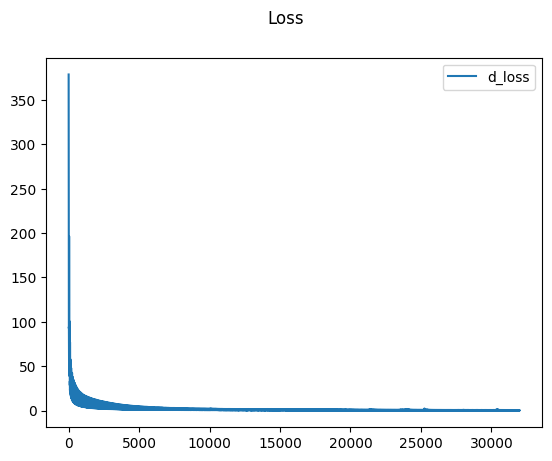

In [247]:
mlt.suptitle('Loss')
mlt.plot(errors_generator, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


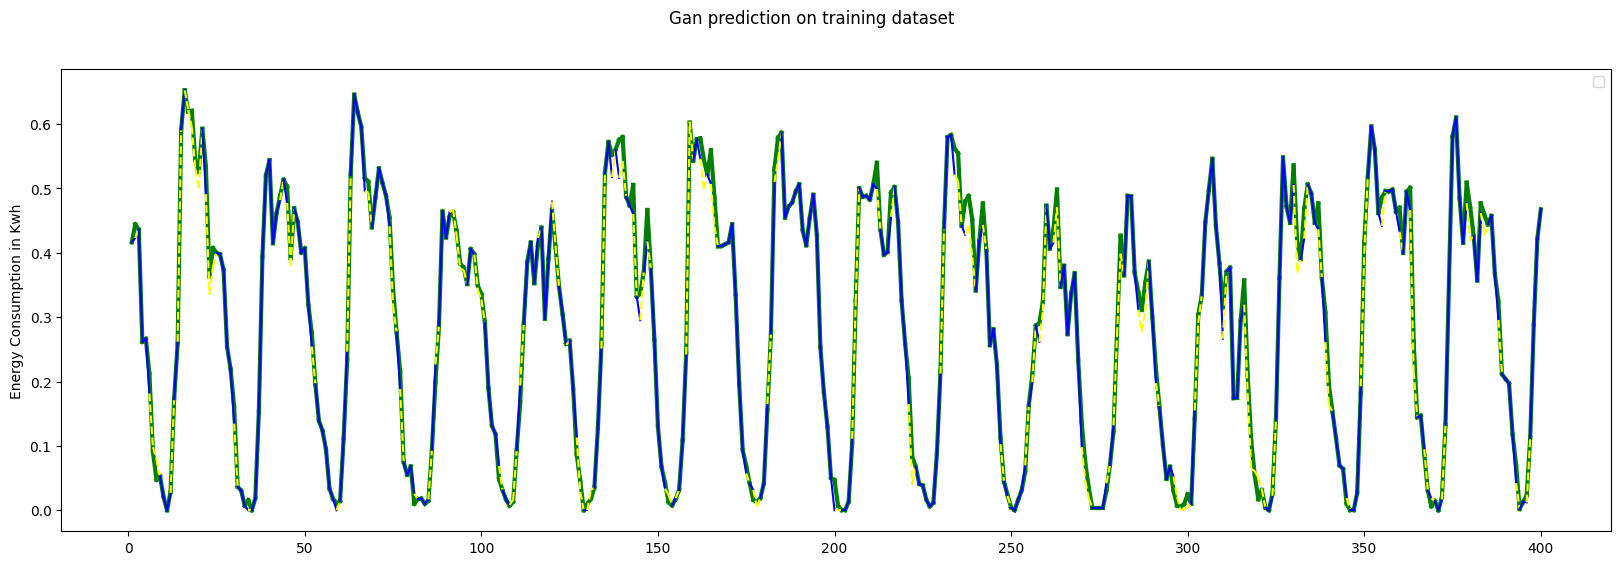

In [64]:
plot_imputation_results(real_dataset[:, -1, :].detach().cpu().numpy(), gen_dataset[:, -1, :].detach().cpu().numpy(), mask_data[:, -1, :].detach().cpu().numpy(), 900, 1300, 'Results/test2.png')

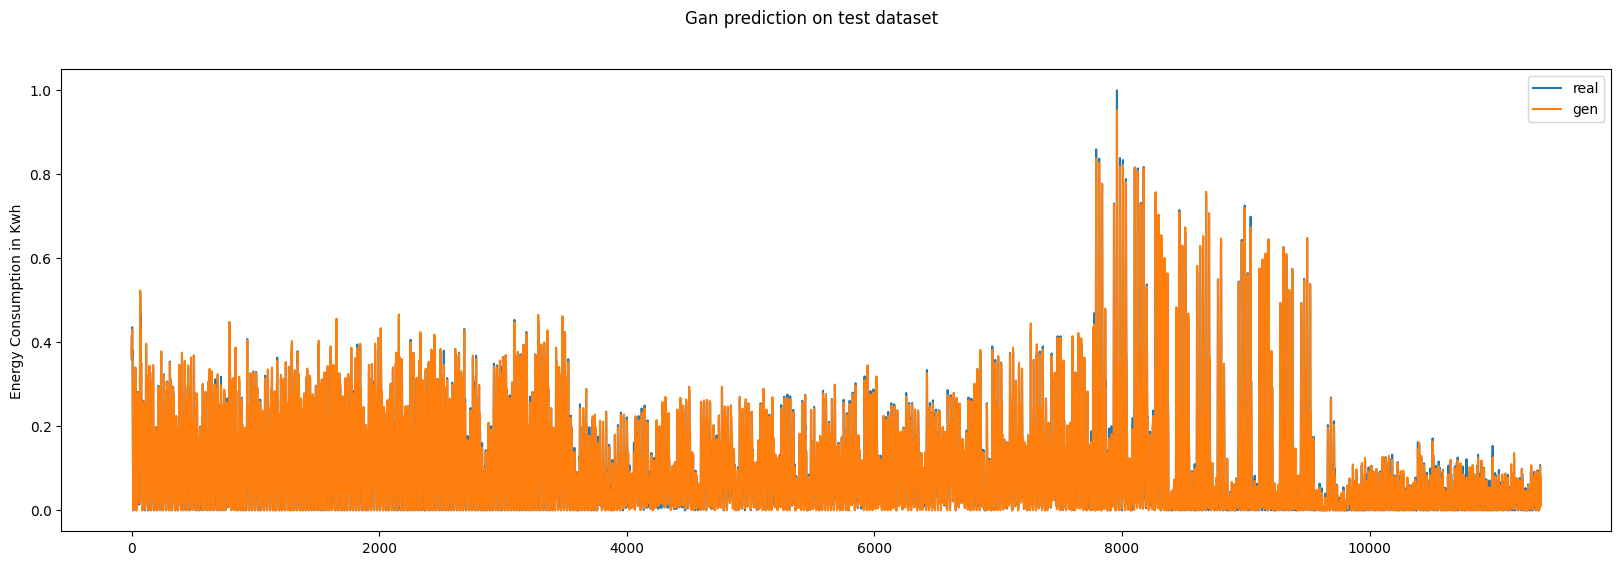

In [248]:
plot_full_dataset(real_dataset[:, -1, :].detach().cpu().numpy(), gen_dataset[:, -1, :].detach().cpu().numpy(), 5000, 60000, 'Results/test1.png', 1)

In [249]:
tr = real_dataset[:, -1, 1].view(-1)
te = gen_dataset[:, -1, 1].view(-1)
ks_statistic, p_value = ks_2samp(tr.detach().cpu().numpy(), te.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.0157470703125
P-value: 0.034040159927440694


Testing-------------------------------------------------------------------------------------------------------------------------------

In [250]:
dataset_name = 'dundee'

In [251]:
df = pd.read_csv("../Data/Processed/" + dataset_name + "_data_with_zero.csv")
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(df, columns=columns)

Grenobile data

In [252]:
# df = pd.read_csv("Data/Raw/EV_data_corrected.csv")
# df['Energy'] = df['Charger_1'] + df['Charger_2'] + df['Charger_3'] + df['Charger_4']
# df.loc[:,'Day'] = pd.to_datetime(df['date_time']).dt.dayofweek + 1
# df = df.astype({'Day': 'int32'})
# df['Week Day'] = (df['Day'] <= 5).astype(int)
# df.rename(columns={'Day': 'Day of week'}, inplace=True)
# df['Year'] = pd.to_datetime(df['date_time']).dt.year
# df['Month'] = pd.to_datetime(df['date_time']).dt.month
# df['Day of month'] = pd.to_datetime(df['date_time']).dt.day
# df['Sum'] = df.groupby(pd.to_datetime(df['date_time']).dt.date)['Energy'].cumsum()
# df.drop(columns=['date_time', 'Charger_1', 'Charger_2', 'Charger_3', 'Charger_4'], inplace=True)
# df['Day of week'], df['Energy'] = df['Energy'].values, df['Day of week'].values
# new_column_order = ['Day of week', 'Energy', 'Week Day', 'Year', 'Month', 'Day of month', 'Sum']
# df.columns = new_column_order

In [253]:
train_ratio = 0.50

In [254]:

missing_train, real_train, mask_train, missing_test, real_test, mask_test = get_train_test_dataset_imputation(df, train_ratio)

In [255]:
real_test = real_test[: -(real_test.shape[0] % batch_size)]
missing_test = missing_test[: -(missing_test.shape[0] % batch_size)]
mask_test = mask_test[: -(mask_test.shape[0] % batch_size)]

In [256]:
step_per_epoch = len(missing_test) // batch_size

In [257]:
# tr = df['Energy']
# mlt.figure(figsize=(20, 6))
# mlt.suptitle('Gan prediction on test dataset')
# mlt.ylabel('Energy Consumption in Kwh')
# mlt.plot(tr, label='real')
# mlt.legend()
# mlt.show()

In [258]:
real_test = torch.from_numpy(real_test).float().to(device)
missing_test = torch.from_numpy(missing_test).float().to(device)
mask_test = torch.from_numpy(mask_test).float().to(device)

In [259]:
real_dataset_test_seq2seq, imputed_dataset, loss, mask_test_result = test_model(model, real_test, missing_test, mask_test, loss_function_seq2seq, step_per_epoch)

In [260]:
real_dataset_test_seq2seq.shape

torch.Size([8192, 7, 8])

In [139]:
imputed_dataset_temp = ((1 - mask_test_result) * real_dataset_test_seq2seq) + (mask_test_result * imputed_dataset)

In [1492]:
save_imputed_data(real_dataset_test_seq2seq, imputed_dataset_temp, "../Data/Imputed/Seq2Seq/" + dataset_name + ".csv", scaler, columns)

In [261]:
real_dataset_test_seq2seq2 = real_dataset_test_seq2seq[:, -1, :]
imputed_dataset2 = imputed_dataset[:, -1, :]

In [262]:
real_dataset_test_seq2seq = pd.DataFrame(real_dataset_test_seq2seq[:, -1, :].detach().cpu().numpy(), columns=columns)
real_dataset_test_seq2seq = scaler.inverse_transform(real_dataset_test_seq2seq)
real_dataset_test_seq2seq = torch.tensor(real_dataset_test_seq2seq)

In [263]:
imputed_dataset = pd.DataFrame(imputed_dataset[:, -1, :].detach().cpu().numpy(), columns=columns)
imputed_dataset = scaler.inverse_transform(imputed_dataset)
imputed_dataset = torch.tensor(imputed_dataset)

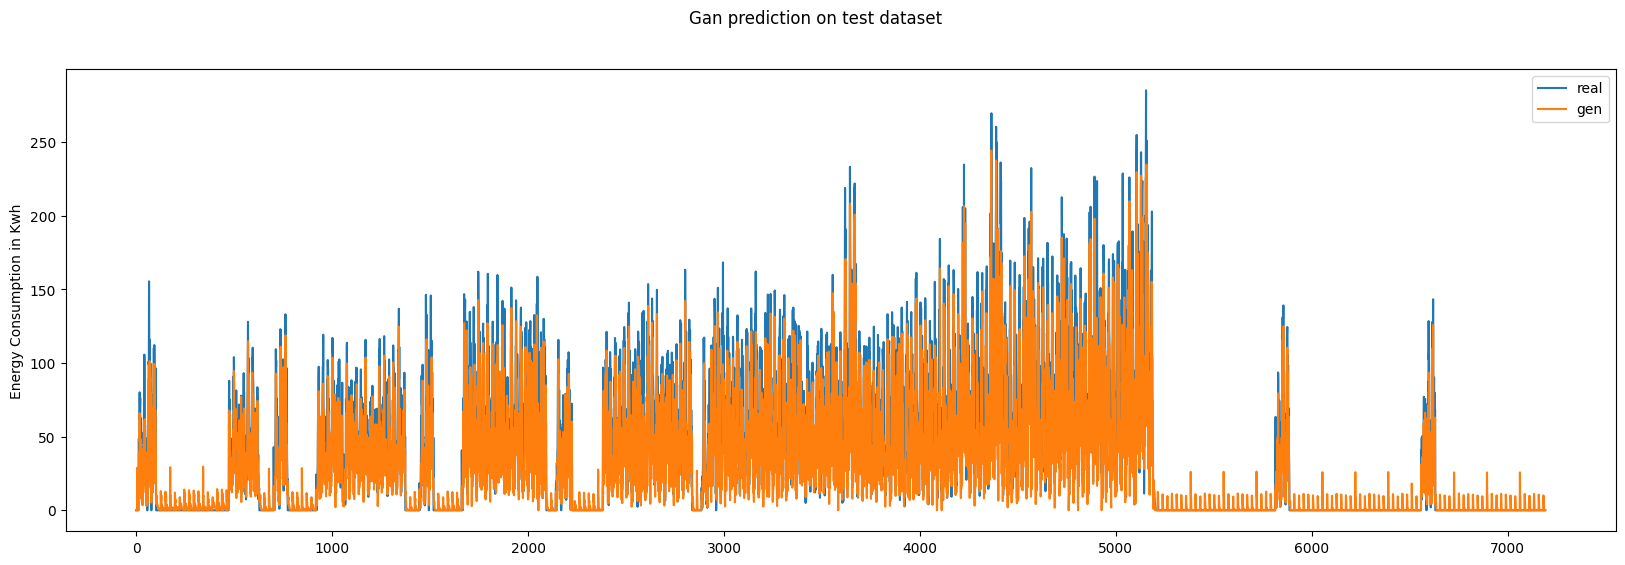

In [264]:
plot_full_dataset(real_dataset_test_seq2seq.detach().cpu().numpy(), imputed_dataset.detach().cpu().numpy(), 1000, 22500, 'Results/test3.png', 1)

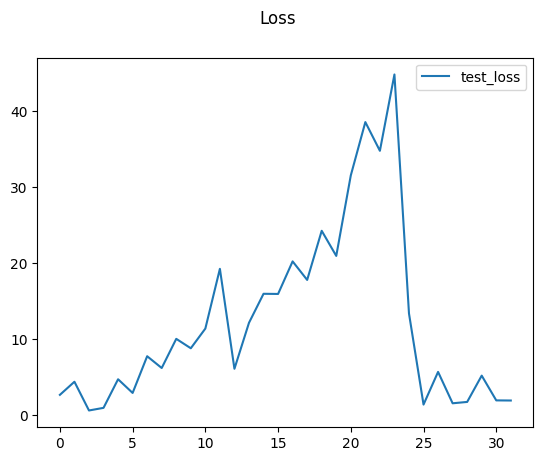

In [265]:
mlt.suptitle('Loss')
#mlt.plot(errors_generator, label='train_loss')
mlt.plot(loss[:], label='test_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

Evaluation----------------------------------------------------------------------------------------------------------------

In [266]:
validation_matrix_imputation(real_dataset_test_seq2seq.detach().cpu().numpy(), imputed_dataset.detach().cpu().numpy(), mask_test_result[:, -1, :].detach().cpu().numpy(), 1)

RMSE:22.46455192565918
MAE: 8.840158
MSE: 504.65607
R-squared: 0.7442378277668116


# Conv Gan

In [622]:
mean = 0  # Mean of the distribution
std_dev = 1  # Standard deviation of the distribution

# Generate random data from a normal distribution
random_data = np.random.normal(loc=mean, scale=std_dev, size=(real_train.size()))
#random_data = np.clip(random_data, 0, 1)
random_data = torch.tensor(random_data,dtype=torch.float32, requires_grad=True).to(device)

In [623]:
loss_function = nn.BCELoss()
generator = ConvGenerator(input_size, hidden_size, input_size).to(device)
discriminator = ConvDiscriminator(input_size, hidden_size).to(device)
optimizer_discriminator = torch.optim.RMSprop(discriminator.parameters(), lr = learning_rate)
optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr = learning_rate)

In [652]:
real_dataset, gen_dataset, errors_generator, errors_discriminator, mask_results = train_ConvGan(generator, discriminator, optimizer_discriminator, optimizer_generator, loss_function, real_train, missing_train, mask_train, step_per_epoch, random_data)

Epoch: 0 Loss D.: 1.4761223354753383e-09 Loss G.: 70198.734375
Epoch: 1 Loss D.: 4.968448763520428e-09 Loss G.: 80611.6015625
Epoch: 2 Loss D.: 3.0461211331100913e-09 Loss G.: 79788.3828125
Epoch: 3 Loss D.: 1.8198056395135609e-09 Loss G.: 69518.578125
Epoch: 4 Loss D.: 4.084095728273951e-09 Loss G.: 80406.6328125
Epoch: 5 Loss D.: 5.117372303686807e-09 Loss G.: 79452.9453125
Epoch: 6 Loss D.: 2.900419815432542e-07 Loss G.: 70457.5703125
Epoch: 7 Loss D.: 1.1794101340001362e-07 Loss G.: 81826.5625
Epoch: 8 Loss D.: 6.401780439091453e-08 Loss G.: 78961.9453125
Epoch: 9 Loss D.: 4.010999887782418e-08 Loss G.: 70463.0703125
Epoch: 10 Loss D.: 2.4900037587372026e-08 Loss G.: 80600.640625
Epoch: 11 Loss D.: 1.732365717543871e-08 Loss G.: 78651.375
Epoch: 12 Loss D.: 1.2863818454889042e-08 Loss G.: 69626.046875
Epoch: 13 Loss D.: 9.594832484083327e-09 Loss G.: 81047.109375
Epoch: 14 Loss D.: 6.3423470919588e-09 Loss G.: 78649.890625
Epoch: 15 Loss D.: 5.379826806262145e-09 Loss G.: 69791.375

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


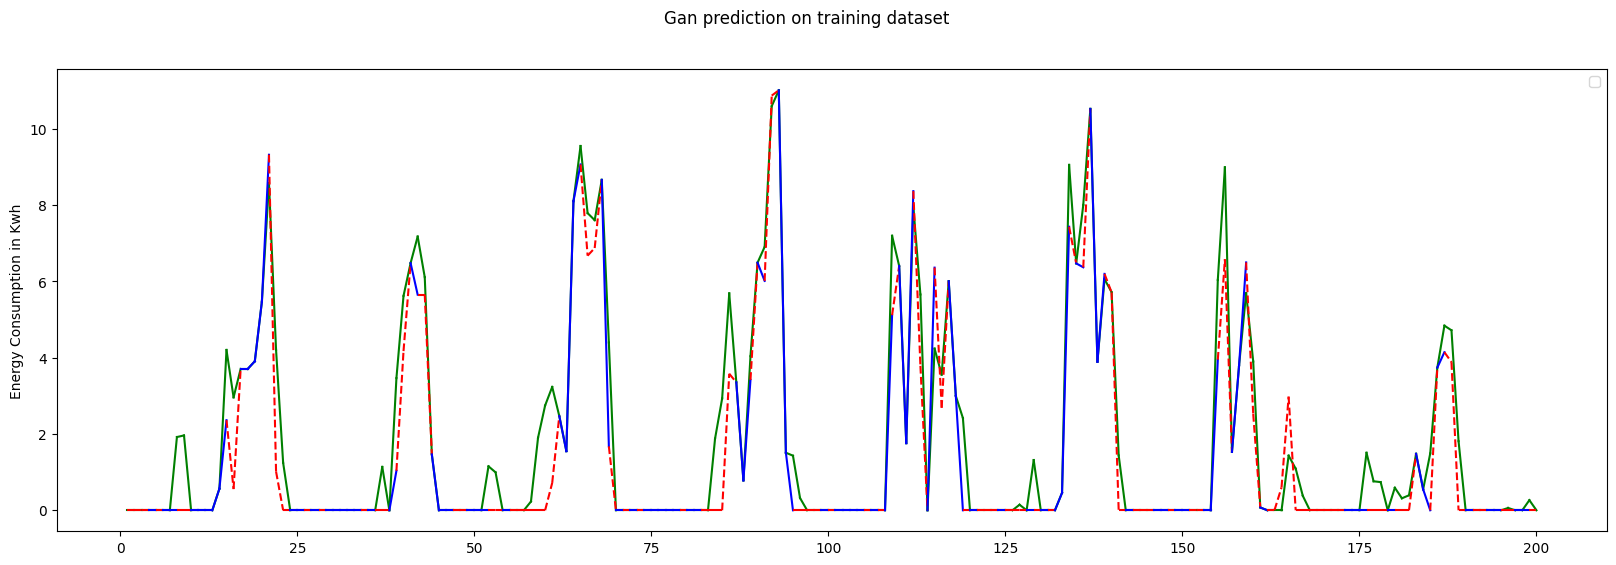

In [519]:
plot_imputation_results(real_dataset, gen_dataset, mask_results,100,300)

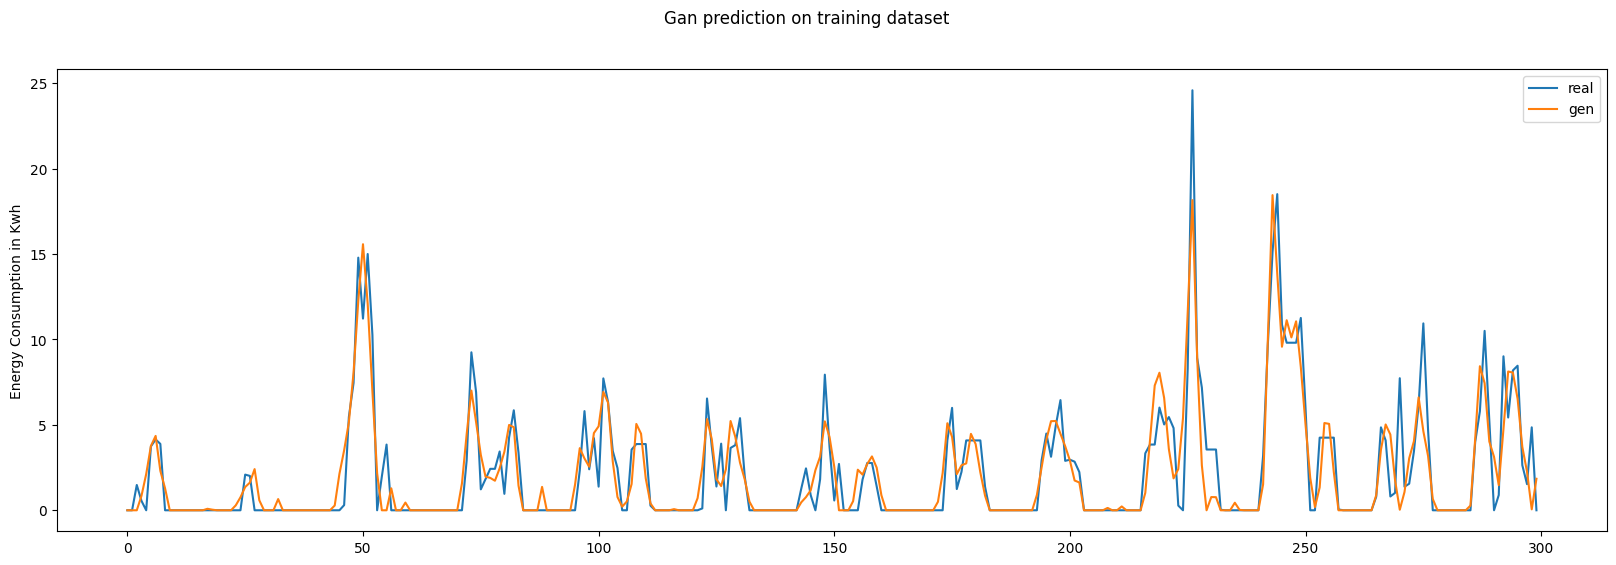

In [660]:
plot_full_dataset(real_dataset, gen_dataset, 300, 600, 3)

In [663]:
tr = real_dataset[:, 7, 0]
te = gen_dataset[:, 7, 0]
ks_statistic, p_value = ks_2samp(tr.detach().cpu().numpy(), te.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic)
print("P-value:", p_value)

KS Statistic: 0.042658730158730174
P-value: 3.4487820648532785e-13


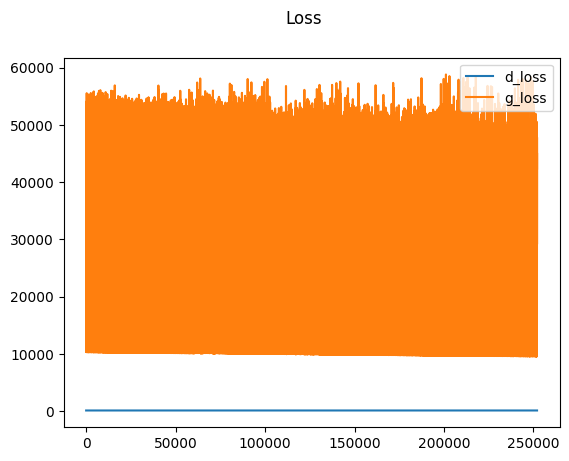

In [485]:
mlt.suptitle('Loss')
mlt.plot(errors_discriminator, label='d_loss')
mlt.plot(errors_generator, label='g_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

In [520]:
RMSE = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy(), squared=False)
print(f'RMSE:{RMSE}')

mae = mean_absolute_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr.detach().cpu().numpy(), te.detach().cpu().numpy())
print("MSE:", mse)

RMSE:1.9196507930755615
MAE: 1.2201656
MSE: 3.685059


In [538]:
random_noise_test = torch.tensor(np.random.randn(real_test.shape[0], lag_size, input_size), dtype=torch.float32, requires_grad=True).to(device)

In [548]:
real_test = torch.from_numpy(real_test).float().to(device)

In [549]:
generator.eval()

ConvGenerator(
  (lstm1): LSTM(1, 12, batch_first=True)
  (batchNorm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=12, out_features=12, bias=True)
  (batchNorm2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(1, 12, batch_first=True)
  (batchNorm3): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=12, out_features=1, bias=True)
  (activation): ReLU()
)

In [550]:
real_data_test_conv, real_label_test_conv = gen_real_batch(real_test.shape[0], 0, real_test)

In [551]:
test_res = generator(real_data_test_conv, random_noise_test)

In [552]:
tr_test = real_data_test_conv[:, -1, 0]
te_test = test_res[:, -1, 0]
ks_statistic_test, p_value_test = ks_2samp(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy())

# Print the results
print("KS Statistic:", ks_statistic_test)
print("P-value:", p_value_test)

KS Statistic: 0.09915702243177597
P-value: 2.3336990538201477e-30


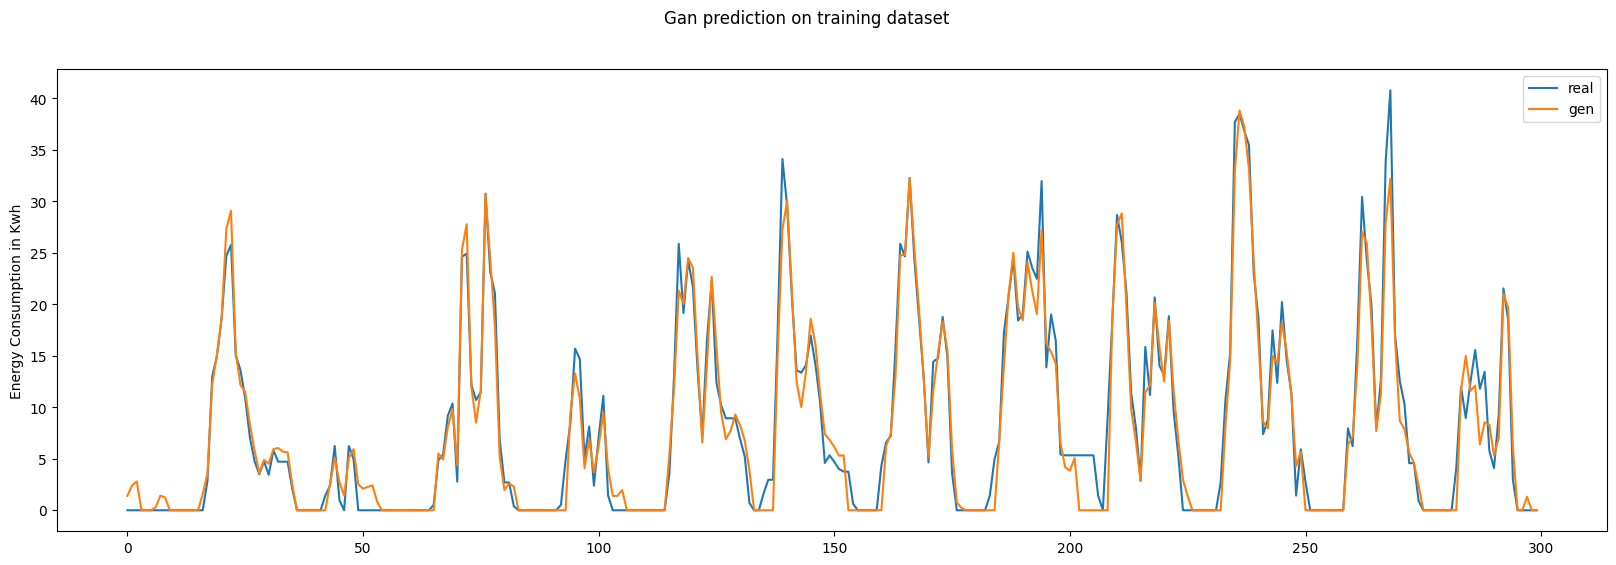

In [554]:
plot_full_dataset(real_data_test_conv, test_res, 300, 600, -1)

In [555]:
RMSE = mean_squared_error(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy(), squared=False)
print(f'RMSE:{RMSE}')

mae = mean_absolute_error(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy())
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(tr_test.detach().cpu().numpy(), te_test.detach().cpu().numpy())
print("MSE:", mse)

RMSE:1.6283469200134277
MAE: 0.9829012
MSE: 2.6515138


# Auto Encoder Model

In [289]:
model = VAE(input_size, hidden_size, 14).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
loss_function_autoencoder = nn.MSELoss()

In [290]:
real_dataset, gen_dataset, errors_generator, mask_data = train_autoEncoder(model, optimizer, loss_function_autoencoder, real_train, missing_train, mask_train, step_per_epoch)

Epoch: 0 Loss G.: 0.43358471989631653
Epoch: 1 Loss G.: 0.3890153765678406
Epoch: 2 Loss G.: 0.3458567261695862
Epoch: 3 Loss G.: 0.2933838665485382
Epoch: 4 Loss G.: 0.24170495569705963
Epoch: 5 Loss G.: 0.22644130885601044
Epoch: 6 Loss G.: 0.2227267175912857
Epoch: 7 Loss G.: 0.21392427384853363
Epoch: 8 Loss G.: 0.20765644311904907
Epoch: 9 Loss G.: 0.20507539808750153
Epoch: 10 Loss G.: 0.20348504185676575
Epoch: 11 Loss G.: 0.1948549747467041
Epoch: 12 Loss G.: 0.19183574616909027
Epoch: 13 Loss G.: 0.19107408821582794
Epoch: 14 Loss G.: 0.18620029091835022
Epoch: 15 Loss G.: 0.18494553864002228
Epoch: 16 Loss G.: 0.18235166370868683
Epoch: 17 Loss G.: 0.18085232377052307
Epoch: 18 Loss G.: 0.17969532310962677
Epoch: 19 Loss G.: 0.17869432270526886
Epoch: 20 Loss G.: 0.17873303592205048
Epoch: 21 Loss G.: 0.1784922033548355
Epoch: 22 Loss G.: 0.17850972712039948
Epoch: 23 Loss G.: 0.17719101905822754
Epoch: 24 Loss G.: 0.1772044450044632
Epoch: 25 Loss G.: 0.17722739279270172
Epo

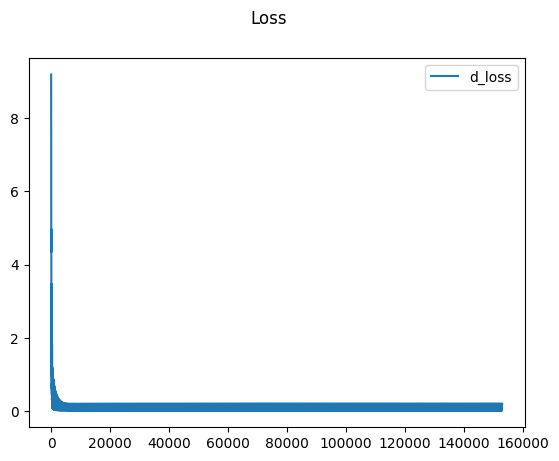

In [278]:
mlt.suptitle('Loss')
mlt.plot(errors_generator, label='d_loss')
mlt.legend()
#mlt.savefig('foo1.png')
mlt.show()

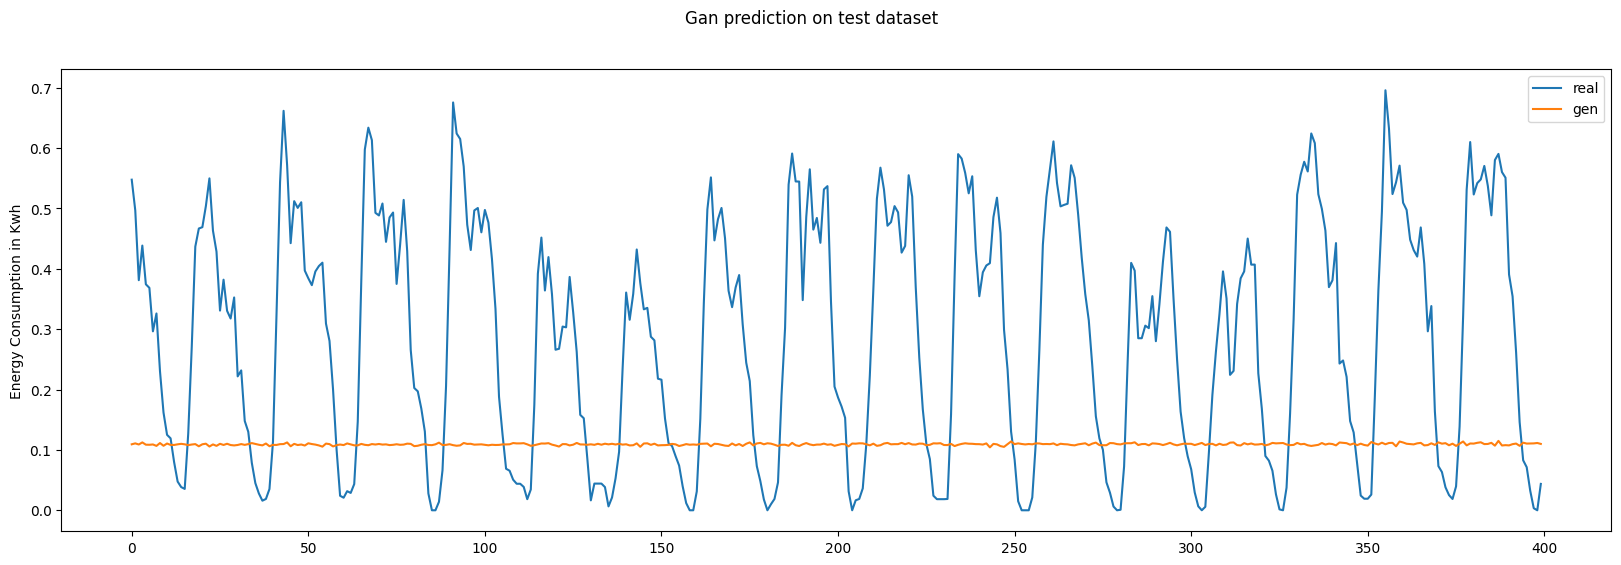

In [279]:
plot_full_dataset(real_dataset[:, -1, :].detach().cpu().numpy(), gen_dataset[:, -1, :].detach().cpu().numpy(), 200, 600, 'Results/test1.png')

# Mean Imputation

In [1620]:
dataset_name = "sap"

In [1621]:
df = pd.read_csv("../Data/Processed/" + dataset_name + "_data_with_zero.csv")

In [1622]:
missing_size = round(missing_ratio * len(df))
missing_data = random_index_noise(df.copy(), missing_size)

In [1624]:
model = MeanImputation()
imputed_data = model(missing_data, 'Energy')

In [1536]:
imputed_data['Hour'] = pd.to_datetime(imputed_data['Start']).dt.hour
imputed_data['Sum'] = imputed_data.groupby(pd.to_datetime(imputed_data['Start']).dt.date)['Energy'].cumsum()
imputed_data.drop(columns=['Start'], inplace=True)

In [1537]:
imputed_data.to_csv("../Data/Imputed/Mean_imputation/" + dataset_name + ".csv", index=False)

# KNN Imputer

In [1599]:
df['Hour'] = pd.to_datetime(df['Start']).dt.hour
df['Sum'] = df.groupby(pd.to_datetime(df['Start']).dt.date)['Energy'].cumsum()
df.drop(columns=['Start'], inplace=True)

In [1600]:
missing_size = round(missing_ratio * len(df))
missing_data = random_index_noise(df.copy(), missing_size)

In [1601]:
# k_neighbour = get_optimum_k(df, missing_data)
k_neighbour = 37

In [1602]:
model = KnnImputer()
imputed_data = model(missing_data, k_neighbour)

In [1603]:
imputed_data = pd.DataFrame(imputed_data, columns=df.columns)

In [1604]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31443 entries, 0 to 31442
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Day of week   31443 non-null  float64
 1   Energy        31443 non-null  float64
 2   Week Day      31443 non-null  float64
 3   Year          31443 non-null  float64
 4   Month         31443 non-null  float64
 5   Day of month  31443 non-null  float64
 6   Hour          31443 non-null  float64
 7   Sum           31443 non-null  float64
dtypes: float64(8)
memory usage: 1.9 MB


In [1605]:
imputed_data['Start'] = imputed_data.apply(lambda row: datetime(int(row['Year']), int(row['Month']), int(row['Day of month'])), axis=1)

In [1606]:
imputed_data['Sum'] = imputed_data.groupby(pd.to_datetime(imputed_data['Start']).dt.date)['Energy'].cumsum()
imputed_data.drop(columns=['Start'], inplace=True)

In [1609]:
df.head(10)

,Day of week,Energy,Week Day,Year,Month,Day of month,Hour,Sum
0,4,3.011908,1,2017,6,1,9,3.011908
1,4,3.922890,1,2017,6,1,10,6.934798
2,4,8.244940,1,2017,6,1,11,15.179739
3,4,13.320642,1,2017,6,1,12,28.500381
4,4,6.241619,1,2017,6,1,13,34.742000
5,4,0.000000,1,2017,6,1,14,34.742000
6,4,0.000000,1,2017,6,1,15,34.742000
7,4,0.000000,1,2017,6,1,16,34.742000
8,4,0.000000,1,2017,6,1,17,34.742000
9,4,0.000000,1,2017,6,1,18,34.742000


In [1607]:
imputed_data.to_csv("../Data/Imputed/Knn/" + dataset_name + ".csv", index=False)